In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jlinops
from jlinops import _CustomLinearOperator

In [61]:
from scipy.sparse.linalg import LinearOperator

In [72]:
l = np.arange(5)

In [74]:
l[:-1]

array([0, 1, 2, 3])

In [125]:
def gradient_operator_matfree_with_sign_corrected_rmatvec(nx, ny):
    """
    Create a matrix-free 2D discrete-gradient operator for a uniform grid of size nx x ny,
    with a sign-corrected rmatvec method for the adjoint operator.
    """
    N = nx * ny  # Total number of grid points

    def matvec(x):
        # Reshape the vector into a 2D grid
        grid = x.reshape(nx, ny)

        # Compute the x-derivative
        dx = np.zeros_like(grid)
        dx[:-1, :] = grid[1:, :] - grid[:-1, :]
        dx[-1, :] = -grid[-1,:]

        # Compute the y-derivative
        dy = np.zeros_like(grid)
        dy[:, :-1] = grid[:, 1:] - grid[:, :-1]
        dy[:, -1] = -grid[:, -1]

        # Flatten and combine the derivatives
        return np.hstack((dx.ravel(), dy.ravel()))

    def rmatvec(y):
        # Reshape the vector into two 2D grids for dx and dy
        dx, dy = np.split(y, 2)
        dx = dx.reshape(nx, ny)
        dy = dy.reshape(nx, ny)

        # Compute the transpose operations with sign correction
        dxt = np.zeros_like(dx)
        dyt = np.zeros_like(dy)

        # Transpose operation for x-derivative
        dxt[1:, :] -= dx[:-1, :]
        dxt[:, :] += dx[:, :]


        # Transpose operation for y-derivative
        dyt[:, 1:] -= dy[:, :-1]
        dyt[:, :] += dy[:, :]


        # Combine, flatten, and apply sign correction
        return -(dxt + dyt).ravel()

    return LinearOperator(shape, matvec=matvec, rmatvec=rmatvec)





In [126]:
nx = 4
ny = 5

# Create the matrix-free gradient operator with sign-corrected rmatvec
gradient_operator_matfree_sign_corrected_rmatvec = gradient_operator_matfree_with_sign_corrected_rmatvec(nx, ny)

# # Perform the adjoint test again using the matrix-free operator with sign-corrected rmatvec
# result_matfree_sign_corrected_rmatvec = adjoint_test_corrected(gradient_operator_matfree_sign_corrected_rmatvec, nx, ny)
# result_matfree_sign_corrected_rmatvec



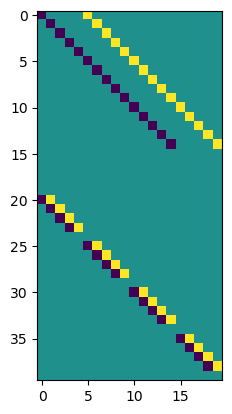

In [132]:
plt.imshow( jlinops.black_box_to_dense(jlinops.Neumann2D( (4,5) )) )
plt.show()

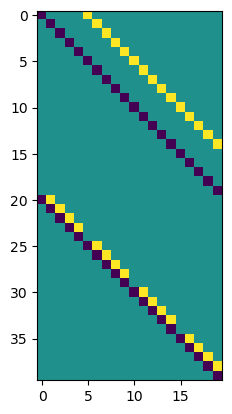

In [127]:
plt.imshow( jlinops.black_box_to_dense(gradient_operator_matfree_sign_corrected_rmatvec) )
plt.show()

In [128]:
R = jlinops.black_box_to_dense(gradient_operator_matfree_sign_corrected_rmatvec)

In [129]:
Rt = jlinops.black_box_to_dense(gradient_operator_matfree_sign_corrected_rmatvec.T)

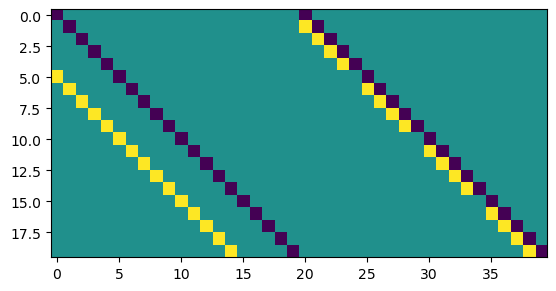

In [130]:
plt.imshow(R.T)
plt.show()

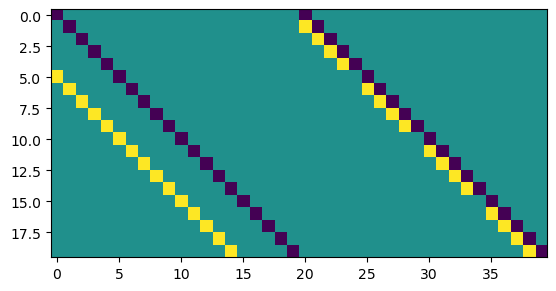

In [131]:
plt.imshow(Rt)
plt.show()

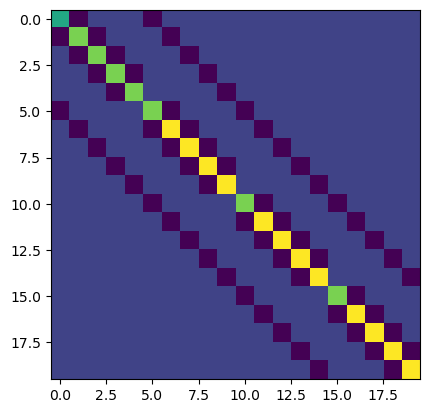

In [82]:
plt.imshow(R.T @ R)
plt.show()

# Misc

In [2]:
R = jlinops.Dirichlet2D((5,4))

In [3]:
Rmat = jlinops.black_box_to_dense(R)

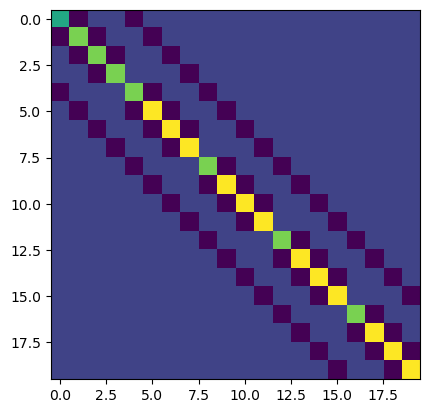

In [6]:
plt.imshow(Rmat.T @ Rmat)
plt.show()

# TEsting

In [10]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.sparse as sps

import jlinops

In [26]:
def first_order_derivative_1d(N, boundary="none"):
    """Constructs a sparse matrix that extracts the (1D) discrete gradient of an input signal.
    Boundary parameter specifies how to handle the boundary conditions. Also returns a dense matrix W
    whose column span the nullspace of the operator (if trivial, W = None).
    """
    
    assert boundary in ["none", "periodic", "zero", "reflexive", "zero_sym"], "Invalid boundary parameter."
    
    d_mat = sps.eye(N)
    d_mat.setdiag(-1,k=1)
    #d_mat = sps.csc_matrix(d_mat)
    d_mat = d_mat.tolil()
    
    if boundary == "periodic":
        d_mat[-1,0] = -1
        W = np.atleast_2d(np.ones(N)).T
    elif boundary == "zero":
        W = None
        pass
    elif boundary == "none":
        d_mat = d_mat[:-1,:]
        W = np.atleast_2d(np.ones(N)).T
    elif boundary == "reflexive":
        d_mat[-1,-1] = 0
        W = np.atleast_2d(np.ones(N)).T
    elif boundary == "zero_sym":
        d_mat = sps.csc_matrix(d_mat)
        new_row = sps.csc_matrix(np.zeros(d_mat.shape[1]))
        d_mat = sps.vstack([new_row, d_mat])
        d_mat[0,0] = -1
        W = None
    else:
        pass
    
    return d_mat, W

In [28]:
R, _ = first_order_derivative_1d(5, boundary="zero_sym")
R = R.toarray()

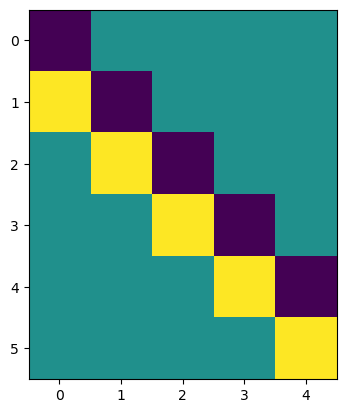

In [29]:
plt.imshow(R)
plt.show()

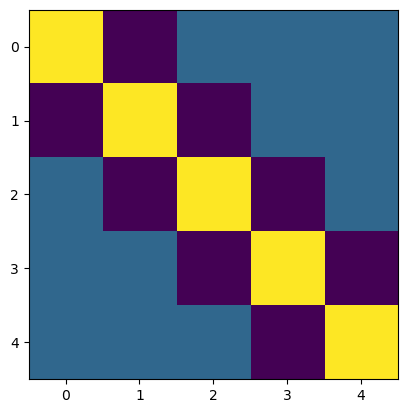

In [30]:
plt.imshow(R.T @ R)
plt.show()

In [50]:
from scipy.linalg import null_space

In [52]:
null_space(R)

array([], shape=(30, 0), dtype=float64)

In [31]:

def build_dirichlet2d_sparse_matrix(grid_shape):
     """Makes a sparse matrix corresponding to the matrix-free Dirichlet2D operator.
     """

     m, n = grid_shape

     Rv, _ = first_order_derivative_1d(m, boundary="zero_sym")
     Rv *= -1.0

     Rh, _ = first_order_derivative_1d(n, boundary="zero_sym")
     Rh *= -1.0

     return sps.vstack([sps.kron(Rv, sps.eye(n)), sps.kron(sps.eye(m), Rh) ])


In [46]:
m, n = 6, 5
R = build_dirichlet2d_sparse_matrix( (m,n) )
R = R.toarray()

In [47]:
R.shape

(71, 30)

In [49]:
m*n*2 + m + n

71

In [44]:
4*5*2

40

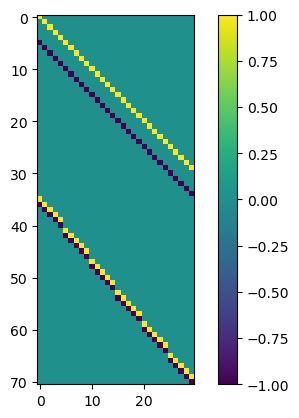

In [53]:
plt.imshow(R)
plt.colorbar()
plt.show()

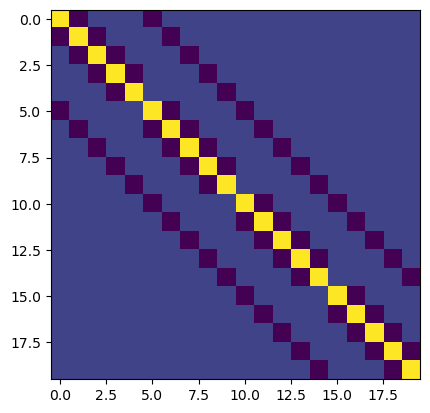

In [37]:
plt.imshow(R.T @ R)
plt.show()

In [39]:
np.linalg.eigvalsh(R.T @ R)

array([0.6499152 , 1.38196601, 1.6499152 , 2.38196601, 2.38196601,
       2.88598318, 3.38196601, 3.38196601, 3.61803399, 3.88598318,
       4.11401682, 4.38196601, 4.61803399, 4.61803399, 5.11401682,
       5.61803399, 5.61803399, 6.3500848 , 6.61803399, 7.3500848 ])

In [57]:

class Dirichlet2D(_CustomLinearOperator):
    """Implements a matrix-free operator R representing the anisotropic discrete gradient of an input vector x
    equipped with Dirichlet boundary conditions. The null space of this operator is spanned by the constant vector,
    and is such that R^T R can be diagonalized using a 2-dimensional DCT.
    """
    def __init__(self, grid_shape, device="cpu"):
        
        # Handle grid shape
        self.grid_shape = grid_shape
        m, n = grid_shape
        shape = (2*m*n, m*n)
        self.M, self.N = self.grid_shape
        
        # Define matvec and rmatvec
        if device == "cpu":
            
            def _matvec(x):

                # Reshape x to have grid shape
                x = x.reshape(self.grid_shape)
                h_diffs, v_diffs = cp.zeros(self.grid_shape), cp.zeros(self.grid_shape)
                h_diffs[:,:-1] = x[:,1:] - x[:,:-1]
                v_diffs[:-1,:] = x[1:,:] - x[:-1,:]
                output = cp.zeros((2,m,n))
                output[0,:,:] = v_diffs
                output[1,:,:] = h_diffs
                return output.flatten()
            
            def _rmatvec(x):
        
                # Reshape x to have (2, M, N) shape
                x = x.reshape((2, m, n))
                p, q = x[0,:,:], x[1,:,:]

                # Pad arrays
                q = np.hstack([ np.zeros(m)[:,None], q])
                p = np.vstack([ np.zeros(n)[None,:], p])

                pdiff = p[1:,:] - p[:-1,:]
                pdiff[-1,:] = - p[-2,:]
                qdiff = q[:,1:] - q[:,:-1]
                qdiff[:,-1] = - q[:,-2]

                # Insert result
                output = -( pdiff + qdiff )

                return output

            
        else:
            
            def _matvec(x):

                # Reshape x to have grid shape
                x = x.reshape(self.grid_shape)
                h_diffs, v_diffs = cp.zeros(self.grid_shape), cp.zeros(self.grid_shape)
                h_diffs[:,:-1] = x[:,1:] - x[:,:-1]
                v_diffs[:-1,:] = x[1:,:] - x[:-1,:]
                output = cp.zeros((2,m,n))
                output[0,:,:] = v_diffs
                output[1,:,:] = h_diffs
                return output.flatten()
            
            def _rmatvec(x):
        
                # Reshape x to have (2, M, N) shape
                x = x.reshape((2, m, n))
                p, q = x[0,:,:], x[1,:,:]

                # Pad arrays
                q = cp.hstack([ np.zeros(m)[:,None], q])
                p = cp.vstack([ np.zeros(n)[None,:], p])

                pdiff = p[1:,:] - p[:-1,:]
                pdiff[-1,:] = - p[-2,:]
                qdiff = q[:,1:] - q[:,:-1]
                qdiff[:,-1] = - q[:,-2]

                # Insert result
                output = -( pdiff + qdiff )

                return output

        
        super().__init__(shape, _matvec, _rmatvec, device=device)

        
    def to_gpu(self):
        return Dirichlet2D(self.grid_shape, device="gpu")
    
    def to_cpu(self):
        return Dirichlet2D(self.grid_shape, device="cpu")
        

In [58]:
R = Dirichlet2D( (4, 5) )

NameError: name 'cp' is not defined

In [52]:
Rmat = jlinops.black_box_to_dense(R)

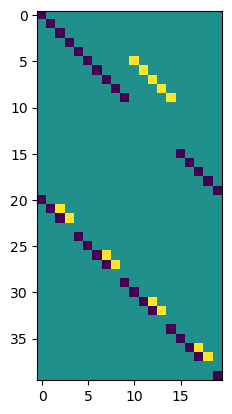

In [53]:
plt.imshow(Rmat)
plt.show()

In [17]:
Q, _ = jlinops.first_order_derivative_1d(4, boundary="zero")

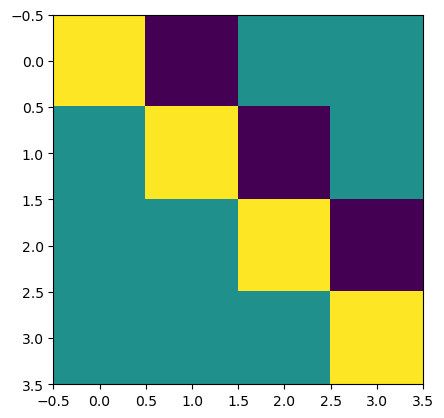

In [18]:
plt.imshow(Q.toarray())
plt.show()

In [20]:
Q, _ = jlinops.first_order_derivative_2d((4, 5), boundary="zero")

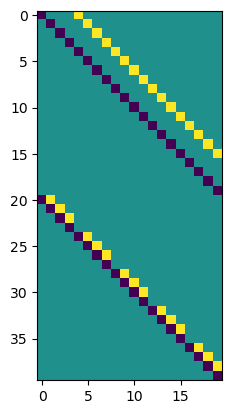

In [42]:
plt.imshow(-Q.toarray())
plt.show()

In [ ]:
r